In [8]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_8452\2216647736.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

# remove rows with outliers
data = data[data["total sulfur dioxide"] < 200]

# z score all variables (including quality)
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [10]:
# convert from pandas dataframe to tensor

# but first drop residual sugar
cols2zscore = cols2zscore.drop("residual sugar")

dataT = torch.tensor(data[cols2zscore].values).float()
sugar = torch.tensor(data["residual sugar"].values).float()
# we'll actually need the labels to be a tensor
sugar = sugar[:, None]

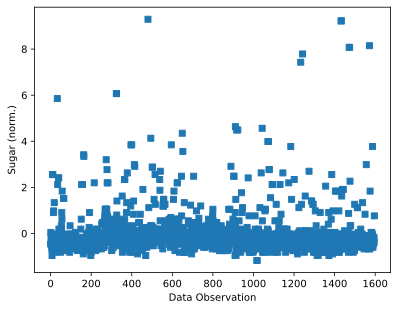

In [11]:
# check values in sugar
plt.plot(sugar, "s")
plt.xlabel("Data Observation")
plt.ylabel("Sugar (norm.)")
plt.show()

In [12]:
train_dataSK, test_dataSK, train_labelsSK, test_labelsSK = train_test_split(dataT, sugar, test_size = .2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_dataSK, train_labelsSK)
test_dataDataset = TensorDataset(test_dataSK, test_labelsSK)

# finally, translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_dataDataset, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataDataset, batch_size = test_dataDataset.tensors[0].shape[0])

In [13]:
# create a class for this model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11, 16)
    
        # hidden layer
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)
    
        # output layer
        self.output = nn.Linear(32, 1)

    # forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x)) # fc = fully connected
        x = F.relu(self.fc2(x))
        return self.output(x)

In [14]:
 # train the model

# training parameter
numepochs = 1000

def trainTheModel():
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    lossfun = nn.MSELoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr = .01)
    
    # train the model
    for epochi in range(numepochs):

        # activate training mode
        winenet.train()
        
        # loop over training data batches
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            
        # now that we've trained through the batches, get avg training accuracy
        trainLoss[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval() # activate testing mode
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad(): # deactivates auto grad
            yHat = winenet(X)
        testLoss[epochi] = lossfun(yHat, y).item()
        
    # function output
    return trainLoss, testLoss

In [19]:
# create a model and train it
winenet = ANNwine()
trainLoss, testLoss= trainTheModel()

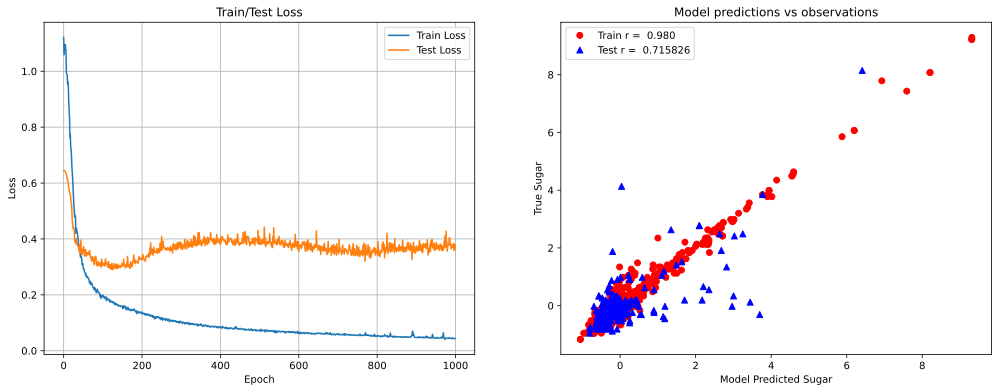

In [20]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize = (17, 6))

ax[0].plot(trainLoss,label = "Train Loss")
ax[0].plot(testLoss, label = "Test Loss")
ax[0].set_title("Train/Test Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid()

# show predictions and real values
yHatTrain = winenet(train_dataSK)
yHatTest = winenet(test_dataSK)
ax[1].plot(yHatTrain.detach(), train_labelsSK, "ro")
ax[1].plot(yHatTest.detach(), test_labelsSK, "b^")
ax[1].set_xlabel("Model Predicted Sugar")
ax[1].set_ylabel("True Sugar")
ax[1].set_title("Model predictions vs observations")

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T, train_labelsSK.T)[1, 0]
corrTest = np.corrcoef(yHatTest.detach().T, test_labelsSK.T)[1, 0]
ax[1].legend([ f"Train r = {corrTrain: .3f}", f"Test r = {corrTest: 3f}"])
plt.show()

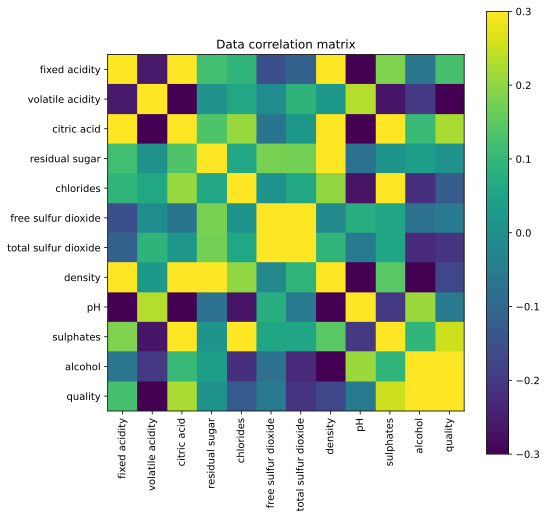

In [21]:
# inspect the correlation matrix
fig = plt.figure(figsize = (8, 8))

plt.imshow(np.corrcoef(data.T), vmin = -.3, vmax = .3)
plt.xticks(range(len(data.keys())), labels = data.keys(), rotation = 90)
plt.yticks(range(len(data.keys())), labels = data.keys())
plt.colorbar()
plt.title("Data correlation matrix")
plt.show()